Data Source: https://designcensus.org/

# Table of Content
1. [Data Preprocessing](#1.0)<br/><br/>
2. [Barplots](#2.0)
    - [Distribution Table for each column](#2.1)
    - [All/AIGA Count Plot for each column](#2.2)
    - [Salary vs. Column plots](#2.3)
<br/><br/>
3. [Heatmaps](#3.0)
4. [Zipcode Analysis](#4.0)
5. [Comparison for AIGA/Non-AIGA](#5.0)

<br>
<br>
<br>
# Import libraries

In [1]:
import numpy as np
import pandas as pd
import math
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import locale
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
locale.setlocale(locale.LC_ALL, '')
%matplotlib inline
import pickle

<a id='1.0'></a>
# Part I, Pre-processing

In [2]:
df = pd.read_csv('DesignCensus2017_Data.csv', encoding = 'utf8')
print('There a a total of ' + str(len(df.columns)) + ' columns.')

There a a total of 43 columns.


### Column name dictionary

In [3]:
col_dict = {}
for col in df.columns:
    index, desc = col.split(' --')
    col_dict['V_' + str(index)] = desc

In [4]:
# function to export df with column names
def df_with_column_names(df, col_dict):
    df_v2 = df.copy()
    df_v2.columns = [col_dict[col] for col in df_v2.columns]
    return df_v2

In [5]:
col_dict

{'V_1': " I've worked in design for:",
 'V_10': 'My immediate team is:',
 'V_11': 'My work touches these industries or sectors:',
 'V_12': 'I’ve been at my current place of work for:',
 'V_13': 'My role is:',
 'V_14': 'My role is:',
 'V_15': 'My role is:',
 'V_16': "I've been in my current role for:",
 'V_17': 'I typically work:',
 'V_18': 'My annual salary is:',
 'V_19': 'My job provides:',
 'V_2': 'I primarily work in:',
 'V_20': 'In my current role, there is:',
 'V_21': 'In my current role, I am:',
 'V_22': 'My job is:',
 'V_23': 'My job stability is:',
 'V_24': 'In addition to my job, I also:',
 'V_25': 'I fuel my daily creativity with coffee:',
 'V_26': "Highest level of education I've completed:",
 'V_27': 'I learned design:',
 'V_28': 'My major focus of study was:',
 'V_29': "Over my career, I've had:",
 'V_3': "I'm also good at:",
 'V_30': "I've shifted my specialty or focus area:",
 'V_31': 'I stay current with design by:',
 'V_32': "I'm a member of:",
 'V_33': "I'd like to ge

### Classify columns (continuous, categorical, multiple pipe)

In [6]:
df.columns = map(lambda x : 'V_' + str(x+1), list(range(len(df.columns)))) 
df['V_36'] = df['V_36'].astype(np.object) # Zipcode --> Convert from numeric to string

In [7]:
continous_cols = ['V_18', 'V_37'] # age and salary
pipe_col = ['V_2', 'V_3','V_5','V_7','V_11','V_19',\
            'V_24', 'V_27', 'V_28', 'V_31', 'V_32',\
            'V_33', 'V_40', 'V_41', 'V_42', 'V_43']

In [8]:
cate_cols = list(set(df.columns) - set(continous_cols))
cate_cols.sort(key = lambda x : int(x.split('_')[1]))

In [9]:
# cate_cols_v2 contains columns without pipes and 3 bad columns
cate_cols_v2 = list(set(cate_cols) - set(pipe_col))
cate_cols_v2.remove('V_35') # "Right now, I can't stop listening to:" - No fixed options
cate_cols_v2.remove('V_36') # "I live in:" - Zipcode
cate_cols_v2.remove('V_8') # "I'm not working because:" - null
cate_cols_v2.sort(key = lambda x : int(x.split('_')[1]))

### Summary of null value for each column

In [11]:
dff = pd.DataFrame(columns=['Column','Desc', 'Null'])
for col in df.columns:
    num_null = df[col].isnull().sum()
    dff = dff.append({'Column': col, 'Desc' : col_dict[col], 'Null' : num_null }, ignore_index=True)
dff.sort_values(by = "Null", ascending= False).head(10) # show top 10 columns with null

,Column,Desc,Null
7,V_8,I'm not working because:,12831
6,V_7,I teach:,12800
14,V_15,My role is:,12769
5,V_6,My company is:,7317
13,V_14,My role is:,7217
4,V_5,My company specializes in:,7198
12,V_13,My role is:,7090
35,V_36,I live in:,2382
41,V_42,The emerging trends and technologies that will...,655
40,V_41,The most critical issues and challenges curren...,439


### Take a look at Salary Outliers

In [12]:
print('The 99% percentile of salary is: ' + \
      str(int(np.percentile(df.V_18.dropna(), 99))))

print('The 90% percentile of salary is: ' + \
      str(int(np.percentile(df.V_18.dropna(), 90))))

print('The 85% percentile of salary is: ' + \
      str(int(np.percentile(df.V_18.dropna(), 85))))

The 99% percentile of salary is: 210799
The 90% percentile of salary is: 120000
The 85% percentile of salary is: 103000


In [ ]:
# take a quick look at salary vs. age
dff = pd.DataFrame()
dff['salary'] = df['V_18'] / 1000
dff['age'] = df['V_37']
dff['salary over million'] = dff['salary'] > 1000
sns.lmplot(data = dff, x = 'salary', y = 'age', fit_reg = False, hue = 'salary over million')
plt.xlabel('Salary (thousand)')
plt.ylabel('Age')

In [14]:
# export a separate file with salary over million record
# df_with_column_names(df[df.V_18 > 1000000], col_dict).to_csv('output_salary_over_million.csv', index = False)

### Break "Age" into groups

In [15]:
def age_break(x):
    if (x < 20): return ('Younger than 20')
    elif (x <= 25): return ('20 to 25')
    elif (x <= 30): return ('25 to 30')
    elif (x <= 35): return ('30 to 35')
    elif (x <= 40): return ('35 to 40')
    elif (x <= 45): return ('40 to 45')
    elif (x <= 50): return ('45 to 50')
    else: return ('Older than 50')

df['V_37'] = df['V_37'].apply(lambda x : age_break(x))
cate_cols.append('V_37') # add Age to categorical variable
continous_cols.remove('V_37') # remove Age from continuous variable

### Exclude outliers for salary

In [ ]:
## Remove outliers for salary
# 1. Null values 
# 2. zero salary
# 3. Top 1% salary

df = df[~((df.V_18.isnull()) |  #remove null 
          (df.V_18 == 0) |  # remove 0
          (df.V_18 > 210000))] # remove extremely high salary

df = df.reset_index()
df = df.drop('index', axis = 1)

### Export raw data with and without salary outliers

In [ ]:
'''
raw_df = pd.read_csv('DesignCensus2017_Data.csv')
salary = raw_df['18 --My annual salary is:']
raw_df_salary_outliers  = raw_df [((salary.isnull()) | (salary == 0) | (salary > 210000))]
raw_df_excluding_outliers  = raw_df [~((salary.isnull()) | (salary == 0) | (salary > 210000))]
raw_df_salary_outliers.to_csv('./export_csv/raw_data_salary_outliers.csv', index = False, encoding = 'utf8')
raw_df_excluding_outliers.to_csv('./export_csv/raw_data_excluding_salary_outliers.csv', index = False, encoding = 'utf8')
del raw_df, raw_df_salary_outliers, raw_df_excluding_outliers
'''

### Script to deal with columns with pipe

In [ ]:
df = df.replace(np.nan,'', regex=True)
pipe_col_dict = {}

for col in pipe_col:
    options = set()
    for row in df[col]:
        arrs = row.split('|') 
        for arr in arrs:
            if arr != '':
                options.add(arr)
    
    pipe_col_dict[col] = {}
    
    index = 1
    for option in options:
        sub_col = col + '_' + str(index)
        df.loc[:,sub_col] = 0
        pipe_col_dict[col][option] = sub_col
        col_dict[sub_col] = col_dict[col] + '-' + option
        index += 1

In [ ]:
# this part takes a few minutes to run
for col in pipe_col:
    row_num = 0;
    for row in df[col]:
        arrs = row.split('|') 
        for arr in arrs:
            if arr != '':
                sub_col = pipe_col_dict[col][arr]
                df.loc[row_num, sub_col] += 1
        row_num += 1

### Output csv w/ and w/o column names

In [ ]:
df.to_csv('./export_csv/processed_output_without_column_names.csv', index = False, encoding = 'utf8')
df_with_column_names(df, col_dict).to_csv(\
    './export_csv/processed_output_with_column_names.csv', index = False, encoding = 'utf8')    

### Export some important variables

In [ ]:
with open('SavedVariables.pckl', 'wb') as f:
    pickle.dump([continous_cols, cate_cols, cate_cols_v2, pipe_col, col_dict, pipe_col_dict], f)

<br>
<br>
<br>
<br>
<a id='2.0'></a>
# Part II, Barplots

<a id='2.1'></a>
### Read in processed data

In [161]:
df = pd.read_csv('./export_csv/processed_output_without_column_names.csv', encoding = 'utf8')
with open('SavedVariables.pckl', 'rb') as f:
    continous_cols, cate_cols, cate_cols_v2, pipe_col, col_dict, pipe_col_dict = pickle.load(f)

<a id='summary_f'></a>
### Basic Summary of each column (only show `top k`)

In [162]:
def summary_cate_col(col, top_k, AllorAIGA = 'All'): #default is for all records
    
    AIGA_col = pipe_col_dict['V_32']['AIGA']
    if AllorAIGA == 'All':
        df_filtered = df
    elif AllorAIGA =="NotAIGA":
        df_filtered = df[df[AIGA_col] == 0]
    else:
        df_filtered = df[df[AIGA_col] == 1]
        
    if col in continous_cols:
        return
    
    elif col in pipe_col:
        dff = pd.DataFrame(columns=['Options','Count','Percent'])
        for key, value in pipe_col_dict[col].items():
            count = df_filtered[value].sum()
            dff = dff.append({'Options': key, 'Count' : count}, ignore_index=True)
    else:
        dff = pd.DataFrame(df_filtered[col].value_counts())
        dff.reset_index(inplace=True)
        dff.columns = ['Options','Count']
    
    dff['Percent'] = dff.Count / len(df_filtered)
    dff = dff.sort_values(by = 'Percent', ascending = False).head(top_k)
    return dff


### Distribution (%) for each column

In [4]:
for col in cate_cols:
    if 'V_8' in col:
        continue
    if 'V_35' in col:
        continue
    if 'V_36' in col:
        continue
    display(str(col) + ' : ' + col_dict[col])
    dff = summary_cate_col(col, 1000)
    display_dff = dff.style.format({'Percent': '{:,.2%}'.format})
    display(display_dff)

"V_1 :  I've worked in design for:"

,Options,Count,Percent
0,1-4 years,3954,31.69%
1,5-9 years,3597,28.83%
2,10-14 years,1986,15.92%
3,15-20 years,1234,9.89%
4,20+ years,1148,9.20%
5,Less than 1 year,558,4.47%


'V_2 : I primarily work in:'

,Options,Count,Percent
9,Graphic Design,8537,68.42%
15,Web Design,4709,37.74%
27,UX Design,4097,32.84%
0,UI Design,3801,30.46%
18,Marketing,3793,30.40%
16,Communication Design,3425,27.45%
6,Interaction Design,2476,19.84%
19,Product Design,2356,18.88%
17,Illustration,2348,18.82%
20,Experience Design,2103,16.86%


"V_3 : I'm also good at:"

,Options,Count,Percent
11,Brainstorming and Ideation,9710,77.82%
4,Project Management,5441,43.61%
13,Drawing or Painting,4969,39.83%
17,Leadership,4960,39.75%
6,Writing,4570,36.63%
0,Mentoring,4395,35.22%
14,Social Media,3963,31.76%
16,Business,2995,24.00%
9,Public Speaking,2690,21.56%
5,Diversity and Inclusion,2466,19.76%


'V_4 : I am currently:'

,Options,Count,Percent
0,A full-time employee in-house,5453,43.70%
1,A full-time employee at an agency or consultancy,3690,29.57%
2,Self-employed or freelancing,1932,15.48%
3,A contract employee in-house,395,3.17%
4,An educator,382,3.06%
5,Other,324,2.60%
6,A contract employee at an agency or consultancy,301,2.41%


'V_5 : My company specializes in:'

,Options,Count,Percent
9,Digital,3337,26.75%
10,Branding,2928,23.47%
1,Print,2330,18.67%
5,Advertising,2046,16.40%
6,Strategy,2039,16.34%
0,Product Design,1315,10.54%
4,Innovation,1067,8.55%
7,Service Design,860,6.89%
8,Social Impact,718,5.75%
2,None of these,413,3.31%


'V_6 : My company is:'

,Options,Count,Percent
0,For-Profit/Corporate,3662,29.35%
1,Startup,676,5.42%
2,Non-Profit,600,4.81%
3,Education,447,3.58%
4,Other,214,1.72%
5,Government,151,1.21%


'V_7 : I teach:'

,Options,Count,Percent
3,Undergraduate school,261,2.09%
4,Graduate school,116,0.93%
2,Programs or workshops,82,0.66%
5,Art school,65,0.52%
1,Technical or Trade school,34,0.27%
0,Junior High or High school,28,0.22%
6,Elementary school,5,0.04%


'V_9 : My organization has:'

,Options,Count,Percent
0,1-10 employees,3144,25.20%
1,1000+ employees,2832,22.70%
2,11-50 employees,2387,19.13%
3,101-250 employees,1136,9.10%
4,51-100 employees,1125,9.02%
5,251-500 employees,862,6.91%
6,501-1000 employees,719,5.76%
7,Not sure,263,2.11%


'V_10 : My immediate team is:'

,Options,Count,Percent
0,2-4 people,4842,38.81%
1,5-10 people,3747,30.03%
2,Just me,2229,17.86%
3,11-20 people,1160,9.30%
4,20+ people,494,3.96%


'V_11 : My work touches these industries or sectors:'

,Options,Count,Percent
48,Marketing and Communications,5301,42.49%
19,Advertising,5129,41.11%
16,Technology,4100,32.86%
38,Education,4025,32.26%
1,Web Services,3527,28.27%
7,Health Care,3409,27.32%
13,Arts,3380,27.09%
24,Retail,3348,26.83%
20,Consumer Products,2955,23.68%
39,Food and Beverage,2719,21.79%


'V_12 : I’ve been at my current place of work for:'

,Options,Count,Percent
0,1-2 years,3730,29.90%
1,Less than 1 year,3534,28.32%
2,3-4 years,2467,19.77%
3,5-7 years,1196,9.59%
4,10+ years,1066,8.54%
5,8-10 years,479,3.84%


'V_13 : My role is:'

,Options,Count,Percent
0,Mid-level specialist,1416,11.35%
1,Owner/Partner,1393,11.16%
2,Art Director,751,6.02%
3,Junior contributor,618,4.95%
4,Creative Director,557,4.46%
5,Other,522,4.18%
6,Senior manager,322,2.58%
7,Director,149,1.19%
8,Intern,98,0.79%
9,Executive,88,0.71%


'V_14 : My role is:'

,Options,Count,Percent
0,Mid-level specialist,2758,22.10%
1,Junior contributor,711,5.70%
2,Director,561,4.50%
3,Senior manager,559,4.48%
4,Team Leader,520,4.17%
5,Other,427,3.42%
6,Group Leader,128,1.03%
7,Executive,73,0.59%
8,Senior Executive,60,0.48%
9,Intern,45,0.36%


'V_15 : My role is:'

,Options,Count,Percent
0,Associate Professor,121,0.97%
1,Professor,59,0.47%
2,Instructor,56,0.45%
3,Program Chair,48,0.38%
4,Other,39,0.31%
5,Lecturer,29,0.23%
6,Adjunct Professor,24,0.19%
7,Dean,3,0.02%
8,Associate Dean,3,0.02%


"V_16 : I've been in my current role for:"

,Options,Count,Percent
0,1-2 years,4352,34.88%
1,Less than 1 year,3865,30.98%
2,3-4 years,2192,17.57%
3,5-7 years,928,7.44%
4,10+ years,769,6.16%
5,8-10 years,366,2.93%


'V_17 : I typically work:'

,Options,Count,Percent
0,40 hours per week,5553,44.51%
1,41-50 hours per week,4070,32.62%
2,Less than 40 hours per week,1913,15.33%
3,51-60 hours per week,695,5.57%
4,60+ hours per week,241,1.93%


'V_19 : My job provides:'

,Options,Count,Percent
1,Paid Time Off,8731,69.98%
4,Medical Insurance,8609,69.00%
12,Dental Insurance,7414,59.42%
11,Employer-matched Retirement,5759,46.16%
3,Life Insurance,5733,45.95%
10,Professional Development,5583,44.75%
7,Paid Parental Leave,4781,38.32%
13,Disability Insurance,4471,35.83%
15,Wellness Programs,3574,28.64%
2,Fitness Benefits,3499,28.04%


'V_20 : In my current role, there is:'

,Options,Count,Percent
0,Some opportunity for advancement,3880,31.10%
1,Promising opportunity for advancement,3256,26.10%
2,Limited opportunity for advancement,3093,24.79%
3,No opportunity for advancement,1478,11.85%
4,Not sure,767,6.15%


'V_21 : In my current role, I am:'

,Options,Count,Percent
0,Learning some new skills,5439,43.59%
1,Learning and increasing my skill set every day,5018,40.22%
2,Learning very little,1699,13.62%
3,Learning nothing,249,2.00%
4,Not sure,69,0.55%


'V_22 : My job is:'

,Options,Count,Percent
0,Pretty good,8014,64.23%
1,The best,2161,17.32%
2,Not great,1942,15.56%
3,Not sure,194,1.55%
4,The worst,163,1.31%


'V_23 : My job stability is:'

,Options,Count,Percent
0,Fairly stable,7152,57.32%
1,Rock solid,3154,25.28%
2,Somewhat shaky,1580,12.66%
3,Non-existent,408,3.27%
4,Not sure,180,1.44%


'V_24 : In addition to my job, I also:'

,Options,Count,Percent
4,Design for friends and family,6966,55.83%
7,Maintain personal projects,6814,54.61%
3,Take occasional freelance projects,6177,49.51%
8,Volunteer,3986,31.95%
5,Have regular freelance clients,2154,17.26%
0,Own my own business,2011,16.12%
1,Teach,1361,10.91%
2,None of these,965,7.73%
6,Have a part-time job,690,5.53%


'V_25 : I fuel my daily creativity with coffee:'

,Options,Count,Percent
0,1-2 cups,5982,47.94%
1,3-4 cups,2349,18.83%
2,"No way, tea",2102,16.85%
3,Other,1439,11.53%
4,5-6 cups,459,3.68%
5,7-8 cups,99,0.79%
6,10+ cups,29,0.23%
7,9-10 cups,18,0.14%


"V_26 : Highest level of education I've completed:"

,Options,Count,Percent
0,Bachelor's degree,8613,69.03%
1,Master's degree,2117,16.97%
2,Some college,628,5.03%
3,Associate's degree,545,4.37%
4,Technical degree or certificate,284,2.28%
5,High School or less,199,1.59%
6,Doctorate,91,0.73%


'V_27 : I learned design:'

,Options,Count,Percent
4,In school,10055,80.59%
2,On the job,8861,71.02%
0,On my own,8014,64.23%
1,From programs or workshops,4554,36.50%
5,Through online training,3970,31.82%
3,From a mentor or apprenticeship,3810,30.54%


'V_28 : My major focus of study was:'

,Options,Count,Percent
10,Graphic Design,8470,67.88%
12,Art,2821,22.61%
24,Visual Design,2424,19.43%
21,Website Design,2080,16.67%
8,Design and Technology,2050,16.43%
7,Communication,1938,15.53%
32,UX and UI,1937,15.52%
17,Illustration,1697,13.60%
25,Digital Media,1645,13.18%
19,Advertising,1580,12.66%


"V_29 : Over my career, I've had:"

,Options,Count,Percent
0,2-3 design jobs,5729,45.92%
1,4-5 design jobs,3052,24.46%
2,1 design job,1736,13.91%
3,6-7 design jobs,1029,8.25%
4,10+ design jobs,545,4.37%
5,8-10 design jobs,386,3.09%


"V_30 : I've shifted my specialty or focus area:"

,Options,Count,Percent
0,1-2 times,6228,49.92%
1,0 times,2967,23.78%
2,3-4 times,1172,9.39%
3,Slowly over time,1095,8.78%
4,Always ready for what's next,1015,8.13%


'V_31 : I stay current with design by:'

,Options,Count,Percent
5,Following design feeds,10127,81.17%
6,Reading online publications,9563,76.65%
2,Following social media,9151,73.34%
7,Discussing with peers,8760,70.21%
0,Reading books/magazines,7084,56.78%
8,Seeking online training,5932,47.54%
1,Attending conferences,5713,45.79%
4,Having a mentor,1910,15.31%
3,None of these,153,1.23%


"V_32 : I'm a member of:"

,Options,Count,Percent
23,None of these,6371,51.06%
12,AIGA,4638,37.17%
28,Creative Mornings,1726,13.83%
20,IXDA,718,5.75%
1,Freelancers Union,395,3.17%
25,AAF,320,2.56%
14,Graphic Artists Guild,169,1.35%
18,SEGD,138,1.11%
26,D&AD,131,1.05%
11,TDC,130,1.04%


"V_33 : I'd like to get better at:"

,Options,Count,Percent
20,UX Design,5396,43.25%
11,Web Design,4818,38.62%
1,UI Design,4647,37.24%
23,Leadership,4488,35.97%
4,Motion Graphics,4460,35.75%
26,Public Speaking,4375,35.06%
18,Coding,4353,34.89%
6,Interaction Design,4117,33.00%
5,Writing,3686,29.54%
9,Photography,3661,29.34%


'V_34 : I am:'

,Options,Count,Percent
0,"Open to opportunities, but not actively looking",5662,45.38%
1,Not interested in a new job right now,2851,22.85%
2,Casually looking for the right opportunity,2591,20.77%
3,Working hard to find my next job,1254,10.05%
4,Not sure,119,0.95%


'V_38 : I am:'

,Options,Count,Percent
0,Female,6718,53.84%
1,Male,5558,44.55%
2,Prefer not to say,98,0.79%
3,Non-binary or third gender,95,0.76%
4,Other,8,0.06%


'V_39 : I consider myself:'

,Options,Count,Percent
0,Not LGBTQ,10018,80.29%
1,LGBTQ,1418,11.36%
2,Prefer not to say,1041,8.34%


'V_40 : My ethnicity is:'

,Options,Count,Percent
7,White or Caucasian,9215,73.86%
3,Asian,1517,12.16%
6,"Latina, Latino, Latinx, or Hispanic",1222,9.79%
1,Black or African American,500,4.01%
0,Other,362,2.90%
5,Prefer not to say,317,2.54%
4,"Native American, First Nations, or First People",147,1.18%
2,Native Hawaiian or Pacific Islander,123,0.99%


'V_41 : The most critical issues and challenges currently facing design are (answer optional):'

,Options,Count,Percent
6,"Design not having a ""seat at the table""",5803,46.51%
5,Diversity in design and tech,5301,42.49%
13,Ethics in design,4847,38.85%
0,Education cost and equity of access,4317,34.60%
4,Consumer vs. social impact focus,3727,29.87%
11,Generational differences in the workforce,3589,28.76%
1,Environmental impacts of design,3358,26.91%
9,Algorithm bias,1961,15.72%
12,Advertising supported content model,1826,14.63%
14,Dark UX patterns,1725,13.83%


'V_42 : The emerging trends and technologies that will have the biggest impact on design are (answer optional):'

,Options,Count,Percent
1,AI and machine learning,6660,53.38%
2,Augmented Reality,5076,40.68%
11,Virtual Reality,4815,38.59%
14,Behavior tracking and modeling,4334,34.74%
0,Internet of Things,3629,29.09%
19,Distributed teams and virtual workplace,3373,27.03%
7,3D printing,3313,26.55%
15,Democratization of design,3275,26.25%
10,Algorithmic design,3100,24.85%
16,Crowdsourcing and open source,2818,22.59%


'V_43 : The most valuable design skills for the future will be (answer optional):'

,Options,Count,Percent
5,Adaptability to tech and social change,8726,69.94%
16,Communication skills,7286,58.40%
17,Empathy,5927,47.50%
2,Asking good questions,5440,43.60%
10,Cross-functional skills,5239,41.99%
13,Storytelling,5189,41.59%
3,Cross-cultural skills,4926,39.48%
0,Observation and listening,4829,38.70%
9,Psychology and human behavior,4682,37.53%
22,Interpersonal skills,4662,37.36%


'V_37 : My age is:'

,Options,Count,Percent
0,25 to 30,3809,30.53%
1,20 to 25,2625,21.04%
2,30 to 35,2541,20.37%
3,35 to 40,1363,10.92%
4,40 to 45,845,6.77%
5,Older than 50,686,5.50%
6,45 to 50,563,4.51%
7,Younger than 20,45,0.36%


<a id='2.2'></a>
### Add plots for each column (All or AIGA-only)

In [5]:
AIGA_col = pipe_col_dict['V_32']['AIGA']
print('The total numeber of AIGA members is: ' + str(len(df[df[AIGA_col] == 1])))

The total numeber of AIGA members is: 4638


In [6]:
def plot_single_column(dff, AllorAIGA):
    # plot bar plot for each option
    plt.figure(figsize=(15, 10))
    sns.set_context("notebook", font_scale=1.5)
    g = sns.barplot(y='Options', x = 'Count',data=dff, color = 'blue', ci = None)
    max_count = max(dff['Count'])
    plt.xlim(0, max_count * 1.5)  

    # add labels
    ax = plt.gca()
    for p,count, percent in zip(ax.patches,dff['Count'],dff['Percent']):
        
        ax.annotate(str('{:,}'.format(count)) +' (' + str('{:,.0%}'.format(percent)) +')', 
                    (p.get_x() + p.get_width()+max_count/50 ,p.get_y()+p.get_height()/2 ),# location
                    xytext=(0, 0), textcoords='offset points',# offset
                    va="center",ha="left", size = 12, rotation=0) #text align and font size
     
    # add info and save
    plt.title(AllorAIGA + '_Distribution of "' + col_dict[col] + '"')
    plt.ylabel(col_dict[col])
    plt.xlabel('Count')
    plt.tight_layout()
    
    plt.savefig('./fig/'+ AllorAIGA + '_Single_Column_' + str(col_dict[col]) + '_Plot.png',dpi=100,format='png')
    plt.savefig('./svgfig/'+ AllorAIGA + '_Single_Column_' + str(col_dict[col]) + '_Plot.svg',dpi=100,format='svg')
    plt.gcf().clear()

In [ ]:
for col in cate_cols:
    if 'V_8' in col:
        continue
    if 'V_35' in col:
        continue
    if 'V_36' in col:
        continue
    
    # get summary table each column (All)
    dff = summary_cate_col(col, 1000, AllorAIGA = 'All')
    plot_single_column(dff, AllorAIGA = 'All')
    
    # get summary table each column (AIGA-Only)
    dff = summary_cate_col(col, 1000, AllorAIGA = 'AIGA-Only')
    plot_single_column(dff, AllorAIGA = 'AIGA-Only')
    
    # get summary table each column (Not AIGA)
    dff = summary_cate_col(col, 1000, AllorAIGA = 'NotAIGA')
    plot_single_column(dff, AllorAIGA = 'NotAIGA')

<a id='2.3'></a>
### Plot `salary` vs. all columns (barplots)

In [ ]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [ ]:
# All figs are saved under 'fig' folder
sns.set_context("notebook", font_scale=2)
for col in cate_cols_v2:
    groupedvalues = df.groupby(col, as_index = False).agg({'V_18': [np.mean, percentile(95), percentile(5),'count']})
    groupedvalues.columns = [col, 'V_18_avg', 'V_18_max', 'V_18_min','V_18_count']
    groupedvalues.sort_values(by = 'V_18_avg', inplace=True)
    order = list(groupedvalues[col])
    
    plt.figure(figsize=(15,10))
    colorPalette = sns.cubehelix_palette(len(order))
    g=sns.barplot(x='V_18', y=col, data=df, estimator= np.mean, \
                order = order,  palette=colorPalette, ci = None)
    plt.xlim(0,150000)
    
    # add data labels
    ax = plt.gca()
    for p,vmin,vavg,vmax,count in zip(ax.patches,groupedvalues['V_18_min'],groupedvalues['V_18_avg'],
                                                 groupedvalues['V_18_max'],groupedvalues['V_18_count']):
        ax.annotate('5%: ' + "{0:n}".format(int(vmin)) +  # value
                    '\nAvg: ' + "{0:n}".format(int(vavg)) +
                    '\n95%: ' + "{0:n}".format(int(vmax)) + 
                    '\nCount: ' + "{0:n}".format(int(count)),
                    (p.get_x() + p.get_width(),p.get_y()+0.5*p.get_height()),# location
                    xytext=(5, 0), textcoords='offset points',# offset
                    va="center", size = 12) #text align and font size
        
    #plot axes and export
    plt.xlabel('Salary')
    plt.ylabel(col_dict[col])
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('./fig/'+ 'Salary vs. ' + col_dict[col] + '_Plot.png',dpi=100)
    plt.savefig('./svgfig/'+ 'Salary vs. ' + col_dict[col] + '_Plot.svg',dpi=100, format='svg')
    plt.gcf().clear()

In [ ]:
# 2. For columns with pipes
dff = pd.DataFrame(columns = ['Col', 'Option', 'Salary'])
for col in pipe_col:
    for option, sub_col in pipe_col_dict[col].items():
        salary_avg = df.loc[df[sub_col] == 1, 'V_18'].mean()
        salary_min = np.percentile(df.loc[df[sub_col] == 1, 'V_18'],5)
        salary_max = np.percentile(df.loc[df[sub_col] == 1, 'V_18'],95)
        count = len(df.loc[df[sub_col] == 1, 'V_18'])
        dff = dff.append({'Col': col, 'Option' : option, 'Salary_min' : salary_min,
                          'Salary_avg' : salary_avg, 'Salary_max' : salary_max, 'Count' :count }, \
                         ignore_index=True)

In [ ]:
# All figs are saved under 'fig' folder
sns.set_context("notebook", font_scale=1.5)
for col in pipe_col:
    dfff = dff[dff.Col == col].sort_values(by = 'Salary_avg')
    order = list(dfff['Option'])
    plt.figure(figsize=(15,10))
    colorPalette = sns.cubehelix_palette(len(order), rot=-.75)
    sns.barplot(x = 'Salary_avg', y = 'Option', data = dfff, estimator= np.mean, \
                order = order, palette=colorPalette)
    plt.xlim(0, max(150000, max(dfff['Salary_avg']) + 120000)) 
    
    # add data labels
    ax = plt.gca()
    for p,vmin,vavg,vmax,count in zip(ax.patches,dfff['Salary_min'], dfff['Salary_avg'],
                                                 dfff['Salary_max'], dfff['Count']):
        ax.annotate('5%: ' + "{0:n}".format(int(vmin)) +  # value
                    '; Avg: ' + "{0:n}".format(int(vavg)) +
                    '; 95%: ' + "{0:n}".format(int(vmax)) +
                    '; Count: ' + "{0:n}".format(int(count)),
                    (p.get_x() + p.get_width(),p.get_y()+0.5*p.get_height()),# location
                    xytext=(5, 0), textcoords='offset points',# offset
                    va="center", size = 12) #text align and font size 
    #plot axes and export    
    plt.xlabel('Salary')
    plt.ylabel(col_dict[col])
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('./fig/'+ 'Salary vs. ' + col_dict[col] + '_Plot.png',dpi=100)
    plt.savefig('./svgfig/'+ 'Salary vs. ' + col_dict[col] + '_Plot.svg',dpi=100, format='svg')
    plt.gcf().clear()

<br>
<br>
<br>
<a id='3.0'></a>
# Part III, Heatmaps

<a id='2.1'></a>
### Read in processed data

In [ ]:
df = pd.read_csv('./export_csv/processed_output_without_column_names.csv', encoding = 'utf8')
with open('SavedVariables.pckl', 'rb') as f:
    continous_cols, cate_cols, cate_cols_v2, pipe_col, col_dict, pipe_col_dict = pickle.load(f)

### Heatmap Analysis

In [ ]:
def plot_heatmap(raw_df, col_1, col_1_desc, col_2, col_2_desc, col_salary):
    df = raw_df.copy()
    sns.set(font_scale = 1)
    df[col_salary] = df[col_salary].apply(lambda x : np.round_(x/1000))
    pivot_table=pd.pivot_table(df, index=col_1, columns=col_2, 
                               values = col_salary, aggfunc=np.mean)
    colorPalette = sns.cubehelix_palette()
    sns.heatmap(pivot_table, annot=True, cmap=colorPalette)
    plt.xlabel(col_2_desc)
    plt.ylabel(col_1_desc)
    plt.title('Average Salary Comparison (K)')
    plt.savefig('./heatmaps/' + col_1_desc + ' vs. ' + col_2_desc + '.svg',format='svg')

In [ ]:
# 1. Gender and Orientation Combo
plot_heatmap(df[df['V_38'] != 'Other'], # exclude GENDER == 'Other'
             'V_38', 'Gender', 
             'V_39', 'Orientation',
             'V_18') #salary

In [ ]:
# 2. Process RACE and combine with GENDER, ORIENTATION (duplicate rows)
hm_heat = pd.DataFrame(columns=['index','Gender', 'Orientation','Race', 'Salary'])# v38, v39, v40, v18
for index, row in df.iterrows():
    for option, subcol in pipe_col_dict['V_40'].items(): #race
        if row[subcol] == 1:
            hm_heat = hm_heat.append({'index': index,
                                      'Gender': row['V_38'],  #gender
                                      'Orientation': row['V_39'], #orientation
                                      'Race': option, 
                                      'Salary': row['V_18']}, ignore_index=True)

In [ ]:
# 2. Race and Gender Combo
plot_heatmap(hm_heat[hm_heat['Gender'] != 'Other'], # exclude GENDER == 'Other'
             'Race', 'Race',
             'Gender', 'Gender', 
             'Salary') #salary

In [ ]:
# 3. Race and Orientation Combo
plot_heatmap(hm_heat[hm_heat['Gender'] != 'Other'], # exclude GENDER == 'Other'
             'Race', 'Race',
             'Orientation', 'Orientation', 
             'Salary') #salary

In [ ]:
# 4. Gender and Education
plot_heatmap(df[df['V_38'] != 'Other'], # exclude GENDER == 'Other'
             'V_38', 'Gender', 
             'V_26', 'Higest Education',
             'V_18') #salary

In [ ]:
# Grouped boxplot
sns.boxplot(x="V_18", y="V_26", hue='V_38', data=df[df['V_38'] != 'Other'], orient="h", palette="Set2")
ax = sns.stripplot(x='V_18', y='V_26', data=df[df['V_38'] != 'Other'], color="black", jitter=0.4, size=1)

# TRY VIOLIN PLOT TO VISUALIZE DISTRIBUTION... NEXT

# How can I include the number of observations that go into each of the bars?
# Just the number of rows that were used for any calculations...

plt.savefig('./boxplot/EducationAndGender_Salary.svg',format='svg')

<br>
<br>
<br>
<a id='4.0'></a>
# Part IV, Geo-data

<a id='2.1'></a>
### Read in processed data

In [241]:
df = pd.read_csv('./export_csv/processed_output_without_column_names.csv', encoding = 'utf8')
with open('SavedVariables.pckl', 'rb') as f:
    continous_cols, cate_cols, cate_cols_v2, pipe_col, col_dict, pipe_col_dict = pickle.load(f)

<a id='2.1'></a>
### Read in zip code data

In [242]:
#Source: https://www.census.gov/geo/maps-data/data/gazetteer2017.html
zip_area = pd.read_csv('./map/2017_Gaz_zcta_national.txt',
                       sep = '\t', dtype = {'GEOID':np.object})
zip_area = zip_area[['GEOID', 'ALAND_SQMI']]
zip_area.columns = ['ZIP', 'AREA_MILE']
zip_area.head(1)

,ZIP,AREA_MILE
0,00601,64.348


In [243]:
#Source: https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?src=CF
zip_pop = pd.read_csv('./map/ACS_16_5YR_B01003_with_ann.csv', skiprows=1)
zip_pop = zip_pop[['Geography', 'Estimate; Total']]
zip_pop['Geography'] = zip_pop.Geography.apply(lambda x: x[-5:])
zip_pop.columns = ['ZIP', 'POP']
zip_pop.head(1)

,ZIP,POP
0,00601,17800


In [244]:
# Join
zip_data = pd.merge(zip_pop, zip_area, on='ZIP')

# Classify: https://policy.tti.tamu.edu/theres-no-such-thing-as-the-suburbs/
zip_data['POP_DEN'] = zip_data.POP / zip_data.AREA_MILE
zip_data['Type'] = zip_data.POP_DEN.apply(
                lambda x: 'Urban' if x >= 3000 else ('Suburban' if x>= 1000 else 'Rural'))
zip_data.head(3)

,ZIP,POP,AREA_MILE,POP_DEN,Type
0,00601,17800,64.348,276.620874,Rural
1,00602,39716,30.621,1297.018386,Suburban
2,00603,51565,31.616,1630.977986,Suburban


In [245]:
print('There are ' + str(sum(df['V_36'].isnull())) + ' records without zip codes')

There are 2224 records without zip codes


In [246]:
# exclude null and merge with zip data
df = df[~df.V_36.isnull()]
df['V_36'] = df['V_36'].apply(lambda x : str(int(x))) # Zipcode --> Convert from numeric to string
df = pd.merge(df, zip_data, left_on = 'V_36', right_on = 'ZIP')

Text(0,0.5,'Salary')

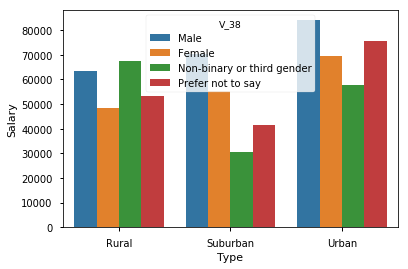

In [248]:
# Plot
sns.set_context("notebook", font_scale=1)
order = ['Rural', 'Suburban', 'Urban']
sns.barplot(x ='Type', # Urban, Suburban, Rual 
            y = 'V_18', # Salary
            hue = 'V_38', # Gender
            data=df[df.V_38 != 'Other'], # Exclude Gnder = 'Other'
            estimator= np.mean, order = order, ci = None)

plt.ylabel('Salary')

In [249]:
# Summarize # of records
pd.pivot_table(df[df.V_38 != 'Other'], values='V_18', index=['V_38'],columns=['Type'], 
               aggfunc=[np.count_nonzero], margins = True)

count_nonzero                         
Type                               Rural Suburban   Urban     All
V_38                                                             
Female                             861.0   1125.0  3525.0  5511.0
Male                               563.0    721.0  2523.0  3807.0
Non-binary or third gender           7.0      8.0    50.0    65.0
Prefer not to say                   14.0     14.0    39.0    67.0
All                               1445.0   1868.0  6137.0  9450.0

# To do: Zipcode --> State --> Region

<br>
<br>
<br>
<a id='5.0'></a>
# Part V, Comparison between AIGA and non-AIGA

<a id='2.1'></a>
### Read in processed data

In [241]:
df = pd.read_csv('./export_csv/processed_output_without_column_names.csv', encoding = 'utf8')
with open('SavedVariables.pckl', 'rb') as f:
    continous_cols, cate_cols, cate_cols_v2, pipe_col, col_dict, pipe_col_dict = pickle.load(f)

In [250]:
import scipy.stats as st

In [251]:
AIGA_col = pipe_col_dict['V_32']['AIGA']

Run the `summary_cate_col` function in **Part II** before next steps [Link to function](#summary_f)

In [252]:
def get_concat_df(col, Percent = False):
    df_1 = summary_cate_col(col, 1000, AllorAIGA = 'AIGA-Only')
    df_2 = summary_cate_col(col, 1000, AllorAIGA = 'NotAIGA')
    df_1['AIGA'] = 'AIGA'
    df_2['AIGA'] = 'Not_AIGA'
    if Percent == True:
        df_1['Count'] = df_1.Count / sum(df_1.Count) * 100
        df_2['Count'] = df_2.Count / sum(df_2.Count) * 100
    dff = pd.concat([df_1, df_2])
    return(dff)

In [253]:
def get_diff_sig(dff):
    cross_df = pd.crosstab(dff.Options, dff.AIGA, values= dff.Count.astype(np.int32), aggfunc=np.mean)
    cross_df.dropna(axis = 0, how = 'any', inplace=True)
    p_value = st.chi2_contingency(cross_df)[1]
    if(p_value < 0.05):
        return 'Yes'
    else:
        return 'No'

In [ ]:
for col in cate_cols:
    if col in ['V_8', 'V_35', 'V_36']:
        continue
    Sig = get_diff_sig(get_concat_df(col))
    sns.set_context("notebook", font_scale=1)
    plt.figure(figsize=(10,8))
    g = sns.barplot(y ='Options', #
            x = 'Count', # Salary
            hue = 'AIGA', # AIGA
            data = get_concat_df(col, Percent = True), # only plot percent
            estimator= np.mean, ci = None)
    plt.title('Significant Difference between AIGA and Non-AIGA: ' + Sig)
    plt.xlabel(col_dict[col])
    plt.tight_layout()
    plt.savefig('./fig/'+ 'Compare_AIGA_for_' + col_dict[col] + '_Plot.png',dpi=100)
    plt.gcf().clear()

### (Not used now) Generate one-hot coded columns for categorical variables

In [ ]:
for col in cate_cols_v2:
    df.replace(np.nan,'', regex=True, inplace=True)
    label_encoder = LabelEncoder()
    feature = label_encoder.fit_transform(df[col])
    feature = feature.reshape(df.shape[0], 1)
    onehot_encoder = OneHotEncoder(sparse=False)
    feature = onehot_encoder.fit_transform(feature)
    for i in range(feature.shape[1]):
        df[col + '-' + str(i + 1)] = np.array(np.matrix(feature).transpose())[i]
        col_dict[col + '-' + str(i + 1)] = col_dict[col] + '-' + label_encoder.classes_[i]
    df.drop(col, axis = 1, inplace = True)

for col in pipe_col:
    df.drop(col, axis = 1, inplace = True)

for col in ['V_8', 'V_35', 'V_36']:
    df.drop(col, axis = 1, inplace = True)

In [ ]:
# output a csv with all columns converted to numeric
df.to_csv('./export_csv/processed_output_all_numeric.csv', index = False, encoding='utf8')